In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

### Reading Data

In [2]:
#Data: https://github.com/nachi-hebbar/Time-Series-Forecasting-LSTM

#https://www.kaggle.com/datasets/bhaveshsonagra/monthly-milk-production
    
    
df = pd.read_csv('monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS' # 'MS' refers to month start frequency
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [3]:
df.shape

(168, 1)

<AxesSubplot:xlabel='Date'>

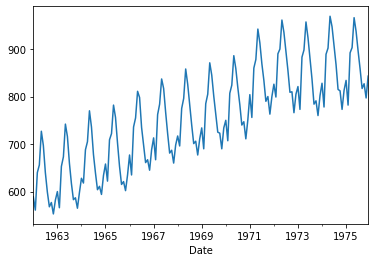

In [4]:
df['Production'].plot()

We can see a general trend (upward moving) and seasonality with certain peaks in the above graph. Let's explore it further.

### Stationarity

Checking stationarity based on Augmented Dicky-Fuller Test (ADF) and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test.

#### 1. ADF Test

DF test uses hypothesis testing to determine the stationarity of data. Hypothesis are defined as below:
- **Null Hypothesis:** Time series is non-stationary i.e., dependent on time.
- **Alternate Hypothesis:** Time series is stationary i.e., independent of time.


We decide the results based on p-values. 
- p > 0.05: FTR null, so data is non-stationary
- p <= 0.05: Reject null, so data is stationary.

In [5]:
result = adfuller(df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.303812
p-value: 0.627427


As out p-value > 0.05, we Fail-To-Reject Null Hypothesis i.e., our data is time dependent as we can see through the graph as well. ADF concludes our data to be non-stationary.

#### 2. KPSS Test

Here, **Null Hypothesis** and **Alternate Hypothesis** are in reverse order with Null Hypothesis focusing on trend stationarity. Since our data exhibits trend, we will check with this test as well.

In [6]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [7]:
kpss_test(df["Production"])

Results of KPSS Test:
Test Statistic            1.173729
p-value                   0.010000
Lags Used                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\aishw\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


KPSS test concludes that we reject null i.e., data is non-stationary.

### Differencing

We do this step to remove stationarity.

In [8]:
df["log"] = np.log(df["Production"])
#df["log_shift"] = np.log(df["Production"].shift(12))
#df["prod_shift"] = df["Production"].shift(12)
df['log_first_diff']=np.sign(df["Production"]-df['Production'].shift(12))*np.log(abs(df["Production"]-df['Production'].shift(12))) #np.log(df['Production']-df['Production'].shift(12))

In [9]:
##Test  for stationarity again with dickey fuller test
result1 = adfuller(df['log'].dropna())
print('ADF Statistic: %f' % result1[0])
print('p-value: %f' % result1[1])
print("\n")
result2 = adfuller(df['log_first_diff'].dropna())
print('ADF Statistic: %f' % result2[0])
print('p-value: %f' % result2[1])

ADF Statistic: -1.754797
p-value: 0.403123


ADF Statistic: -3.307436
p-value: 0.014549


### Seasonal Decompose

In [10]:
def plot_seasonal_decompose (input_data):
    decomposition = sm.tsa.seasonal_decompose(input_data, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(18,8)
    plt.show()

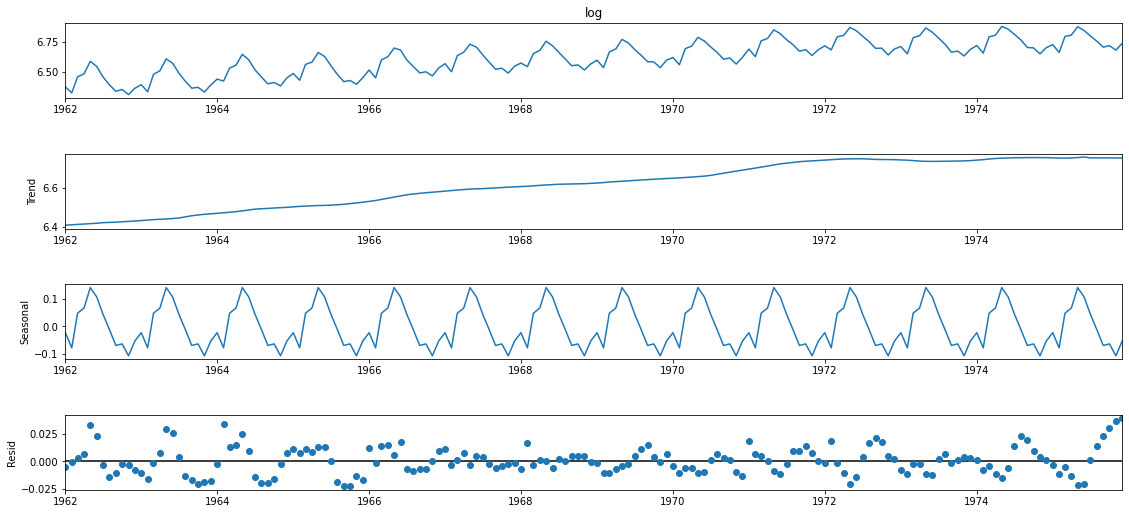

In [11]:
plot_seasonal_decompose(df['log'].dropna())

- **Production:** This is similar to the graph we plotted before for the data in general.
- **Trend:** This shows trend of the data. We can see that our trend is upward before going flat.
- **Seasonal:** This shows seasonality of the data. It's similar to the production graph but without trend associated to it. We can see seasonality consistent throughout the years for our data.
- **Residual:** This shows the residuals for our data.

### Plotting ACF and PACF (p, d, q)

- ACF stands for Auto Correlation Function while, PACF stands for Partial Auto Correlation Function.
- These plots helps analyze the similarity between the series itself and its lagged version.


**PACF is used to determine AR part**

We can note a sharp decline in PACF plots which is called "shutt off". The values after a certain peak decline towards zero. We consider the non-zero peaking values. In our plot, for our log column, we see a decline after second point. Therefore, **p=2**.


**ACF is used to determine MA part**

Since our ACF doesn't appear over differenced nor do we have have negative lag, we do not consider MA lags. Therefore, **q=0**.


**Differencing**

Since, differencing only once is giving us good results, we set **d=1**.

### ACF plot

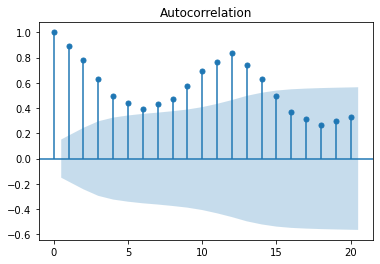

In [12]:
plot_acf(x=df['log'], lags=20)
plt.show()

### PACF plot

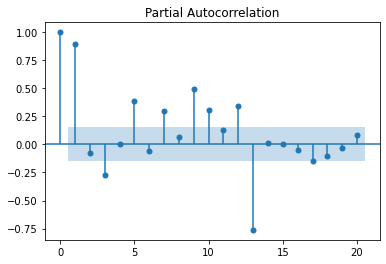

In [13]:
plot_pacf(x=df['log'], lags=20)
plt.show()

### Splitting to training and test

In [14]:
df_train = df[:160]
df_train.shape

(160, 3)

In [15]:
df_test = df[160:]
df_test.shape

(8, 3)

### Modelling

Since our data exhibits trend and seasonality, we consider ARIMA model and AutoRegressive Model (lag = 12) to form our model.

### 1. ARIMA

In [16]:
# importing library for ARIMA
from statsmodels.tsa.arima.model import ARIMA

#using ARIMA model on data
model = ARIMA(df_train['log'].dropna(), order=(2, 1, 0), seasonal_order=(2, 1, 0, 12))
model_fit = model.fit()

In [17]:
# make prediction
y_pred_arima = model_fit.predict(len(df_train), (len(df_train)+8), typ='levels')
print("Next LEC estimate (ARIMA):\n",round(np.exp(y_pred_arima),0))

Next LEC estimate (ARIMA):
 1975-05-01    966.0
1975-06-01    940.0
1975-07-01    899.0
1975-08-01    858.0
1975-09-01    807.0
1975-10-01    808.0
1975-11-01    770.0
1975-12-01    810.0
1976-01-01    831.0
Freq: MS, Name: predicted_mean, dtype: float64


In [18]:
df_test['forecast_arima'] = model_fit.predict(start=160,end=167) 
df_test['forecast_arima'] = round(np.exp(df_test['forecast_arima']),0)

### 2. AR Model

In [19]:
# importing library for Autoregressive model
from statsmodels.tsa.ar_model import AutoReg

# fitting data to AR model
model = AutoReg(df_train['log'].dropna(), lags=12)
model_fit = model.fit()

y_pred_ar = model_fit.predict(len(df_train), (len(df_train)+8))
print("Next LEC estimate (AutoRegressive):\n",round(np.exp(y_pred_ar),0))

Next LEC estimate (AutoRegressive):
 1975-05-01    976.0
1975-06-01    967.0
1975-07-01    928.0
1975-08-01    889.0
1975-09-01    829.0
1975-10-01    832.0
1975-11-01    790.0
1975-12-01    821.0
1976-01-01    847.0
Freq: MS, dtype: float64


In [20]:
df_test['forecast_AR'] = model_fit.predict(start=160,end=167) 
df_test['forecast_AR'] = round(np.exp(df_test['forecast_AR']),0)

<AxesSubplot:xlabel='Date'>

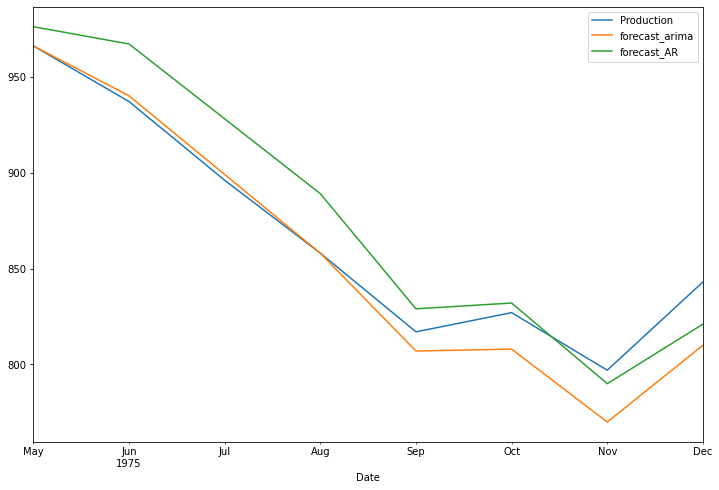

In [21]:
df_test[['Production','forecast_arima', 'forecast_AR']].plot(figsize=(12,8))

The above plot shows the predicted values of last 8 months (test data) using both ARIMA and AR models.